In [3]:
import pandas as pd
import numpy as np
from plotnine import *
from scipy.stats import gmean
import matplotlib.pyplot as plt

plt.xkcd()

In [4]:
def filter_vf2layout(result):
    return result[~(result['cx'] <= 1)]
    # remove rows with 'cx', 'zzphase', 'sqisw' column properties are all 1
    return result[~((result['cx'] == 1) & (result['zzphase'] == 1) & (result['sqisw'] == 1) & (result['can_xx'] == 1) & (result['can_xy'] == 1))]
    

In [5]:
result_sabre_chain = filter_vf2layout(pd.read_csv('../results/sabre-chain.csv'))
result_canopus_chain = filter_vf2layout(pd.read_csv('../results/canopus-chain.csv'))
result_toqm_chain = filter_vf2layout(pd.read_csv('../results/toqm-chain.csv'))
result_bqskit_chain = filter_vf2layout(pd.read_csv('../results/bqskit-chain.csv'))

result_sabre_hhex = filter_vf2layout(pd.read_csv('../results/sabre-hhex.csv'))
result_canopus_hhex = filter_vf2layout(pd.read_csv('../results/canopus-hhex.csv'))
result_toqm_hhex = filter_vf2layout(pd.read_csv('../results/toqm-hhex.csv'))
result_bqskit_hhex = filter_vf2layout(pd.read_csv('../results/bqskit-hhex.csv'))

result_sabre_square = filter_vf2layout(pd.read_csv('../results/sabre-square.csv'))
result_canopus_square = filter_vf2layout(pd.read_csv('../results/canopus-square.csv'))
result_toqm_square = filter_vf2layout(pd.read_csv('../results/toqm-square.csv'))
result_bqskit_square = filter_vf2layout(pd.read_csv('../results/bqskit-square.csv'))

ISA_TYPES = ['cx', 'zzphase', 'sqisw', 'can_xx', 'can_xy', 'zzphase_', 'sqisw_', 'het']

In [6]:
# for isa in ISA_TYPES:
#     print(f'ISA: {isa}')
#     chain_outliers = (result_canopus_chain['program'].iloc[np.where(result_canopus_chain[isa] / result_sabre_chain[isa] > 1)[0]]).tolist()
#     hhex_outliers = (result_canopus_hhex['program'].iloc[np.where(result_canopus_hhex[isa] / result_sabre_hhex[isa] > 1)[0]]).tolist()
#     square_outliers = (result_canopus_square['program'].iloc[np.where(result_canopus_square[isa] / result_sabre_square[isa] > 1)[0]]).tolist()
#     print('chain outliers:', chain_outliers)
#     print('hhex outliers:', hhex_outliers)
#     print('square outliers:', square_outliers)
#     print('')


In [7]:
len(result_canopus_chain), len(result_canopus_hhex), len(result_canopus_square)

(11, 13, 11)

In [8]:
def plot_avg_comp(result_sabre, result_canopus, title):

    avg_overhead_sabre = [gmean(result_sabre[isa]) for isa in ISA_TYPES]
    avg_overhead_canopus = [gmean(result_canopus[isa]) for isa in ISA_TYPES]

    reductions = ['-{}%'.format(round(100 * (1 - gmean(result_canopus[isa] / result_sabre[isa])), 2)) for isa in ISA_TYPES]

    comp = pd.DataFrame({
        'ISA': ISA_TYPES,
        'Sabre': avg_overhead_sabre,
        'Canopus': avg_overhead_canopus
    })

    # 创建标注数据框，包含每个ISA对应的reduction值
    annotation_data = pd.DataFrame({
        'ISA': ISA_TYPES,
        'reduction': reductions,
        'y_pos': [min(avg_overhead_sabre[i], avg_overhead_canopus[i]) * 1.05 for i in range(len(ISA_TYPES))],
        'x_pos': [i + 1.25 for i in range(len(ISA_TYPES))]
    })

    p_avg_comparison = (
    comp
    .melt(id_vars='ISA', var_name='Method', value_name='Overhead')
    .assign(
        Method=lambda df: df['Method'].astype('category'),
        ISA=lambda df: pd.Categorical(
            df['ISA'],
            categories=ISA_TYPES,
            ordered=True
        )
    )
    .pipe(lambda df: df.assign(Method=df['Method'].cat.reorder_categories(['Sabre', 'Canopus'])))
    .pipe(lambda df: (
        ggplot(df, aes(x='ISA', y='Overhead', fill='Method')) +
        geom_bar(stat='identity', position='dodge', alpha=0.8) +
        geom_text(data=annotation_data,
                mapping=aes(x='x_pos', y='y_pos', label='reduction'),
                size=9, ha='center', va='bottom', inherit_aes=False) +
        labs(title=title, x='', y='') +
        scale_fill_manual(values=['#2ECC71', '#3498DB','#E74C3C']) +
        theme_minimal() +
        theme(
            axis_text_x=element_text(rotation=0, hjust=0.5, size=12),
            axis_text_y=element_text(size=12),
            legend_title=element_blank(),
            legend_position=(0.975,0.975),
            legend_text=element_text(size=13),
            figure_size=(8, 3.5),
            plot_title=element_text(size=16, face='bold'),
            plot_subtitle=element_text(size=12, face='italic')
            )
        ))
    )
    return p_avg_comparison

In [17]:
def plot_avg_comp3(result_sabre, result_toqm, result_bqskit, result_canopus, title):

    avg_overhead_sabre = [gmean(result_sabre[isa]) for isa in ISA_TYPES]
    avg_overhead_toqm = [gmean(result_toqm[isa]) for isa in ISA_TYPES]
    avg_overhead_bqskit = [gmean(result_bqskit[isa]) for isa in ISA_TYPES]
    avg_overhead_canopus = [gmean(result_canopus[isa]) for isa in ISA_TYPES]

    reductions_vs_sabre = ['-{}%'.format(round(100 * (1 - gmean(result_canopus[isa]) / gmean(result_sabre[isa])), 2)) for isa in ISA_TYPES]
    reductions_vs_toqm = ['-{}%'.format(round(100 * (1 - gmean(result_canopus[isa]) / gmean(result_toqm[isa])), 2)) for isa in ISA_TYPES]
    reductions_vs_bqskit = ['-{}%'.format(round(100 * (1 - gmean(result_canopus[isa]) / gmean(result_bqskit[isa])), 2)) for isa in ISA_TYPES]

    print('reductions_vs_sabre:', reductions_vs_sabre)
    print('reductions_vs_toqm:', reductions_vs_toqm)
    print('reductions_vs_bqskit:', reductions_vs_bqskit)

    comp = pd.DataFrame({
        'ISA': ISA_TYPES,
        'Sabre': avg_overhead_sabre,
        'TOQM': avg_overhead_toqm,
        'BQSKit': avg_overhead_bqskit,
        'Canopus': avg_overhead_canopus
    })

    p_avg_comparison = (
    comp
    .melt(id_vars='ISA', var_name='Method', value_name='Overhead')
    .assign(
        Method=lambda df: df['Method'].astype('category'),
        ISA=lambda df: pd.Categorical(
            df['ISA'],
            categories=ISA_TYPES,
            ordered=True
        )
    )
    .pipe(lambda df: df.assign(Method=df['Method'].cat.reorder_categories(['Sabre', 'TOQM', 'BQSKit', 'Canopus'])))
    .pipe(lambda df: (
        ggplot(df, aes(x='ISA', y='Overhead', fill='Method')) +
        geom_bar(stat='identity', position='dodge', alpha=0.8) +
        labs(title=title, x='', y='') +
        scale_fill_manual(values=['#3498DB', '#2ECC71', '#E67E22', '#E74C3C']) +  # use orange for TOQM
        theme_minimal() +
        theme(
            axis_text_x=element_text(rotation=0, hjust=0.5, size=12),
            axis_text_y=element_text(size=12),
            legend_title=element_blank(),
            legend_position=(0.975,0.975),
            legend_direction='horizontal',
            legend_text=element_text(size=11), text=element_text(family='Comic Sans MS'),
            figure_size=(8, 3.5),
            plot_title=element_text(size=16, face='bold'),
            plot_subtitle=element_text(size=12, face='italic')
            )
        ))
    )
    return p_avg_comparison

reductions_vs_sabre: ['-37.38%', '-38.47%', '-35.7%', '-37.45%', '-38.43%', '-36.79%', '-34.06%', '-38.84%']
reductions_vs_toqm: ['-30.89%', '-34.98%', '-26.71%', '-34.77%', '-32.8%', '-31.66%', '-25.5%', '-34.16%']
reductions_vs_bqskit: ['-25.8%', '-28.17%', '-23.32%', '-27.98%', '-32.84%', '-30.29%', '-19.73%', '-27.36%']


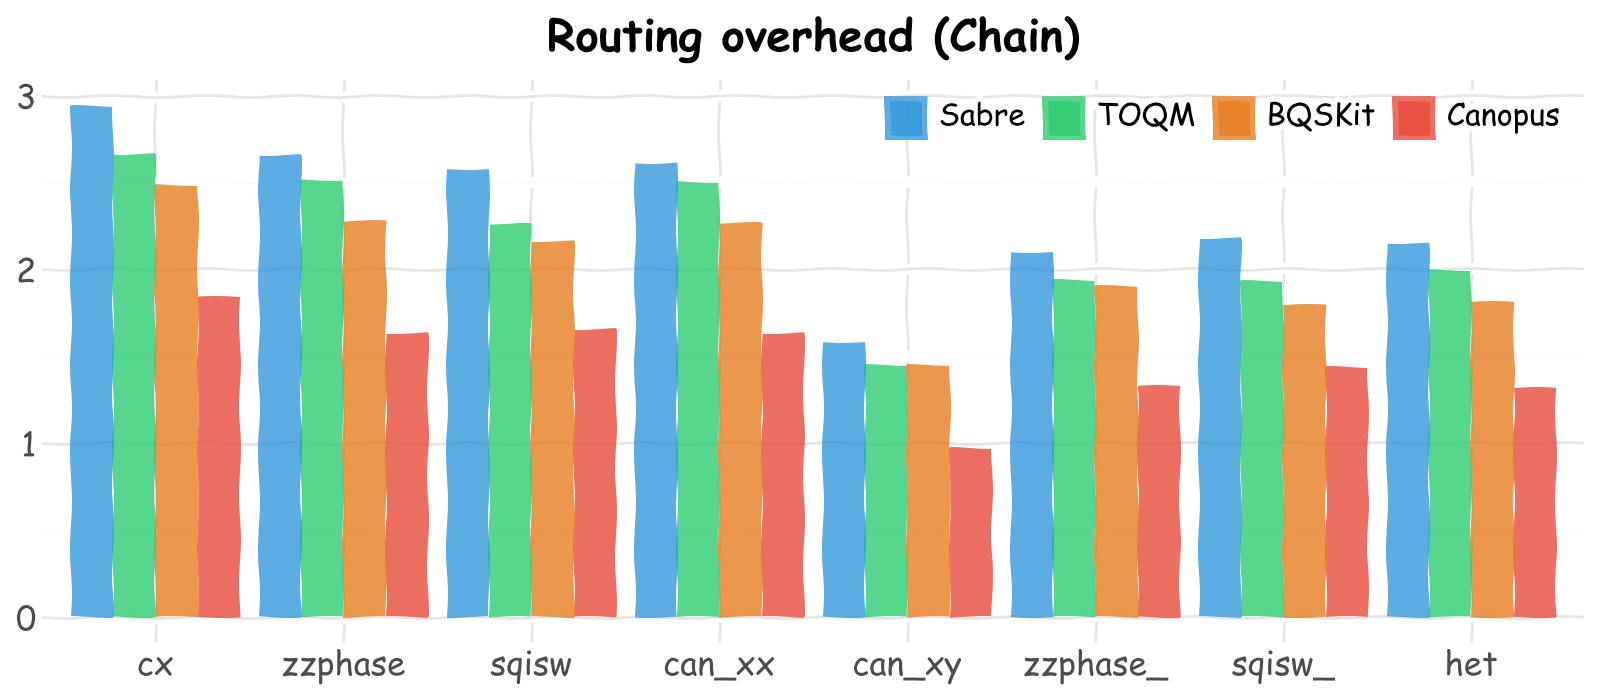

In [16]:
plot_avg_comp3(result_sabre_chain, result_toqm_chain, result_bqskit_chain, result_canopus_chain, 'Routing overhead (Chain)')


reductions_vs_sabre: ['-36.79%', '-35.35%', '-35.27%', '-35.09%', '-34.34%', '-36.06%', '-32.77%', '-35.18%']
reductions_vs_toqm: ['-27.66%', '-28.41%', '-27.53%', '-28.78%', '-28.67%', '-29.4%', '-23.92%', '-28.32%']
reductions_vs_bqskit: ['-34.7%', '-38.37%', '-34.04%', '-32.85%', '-32.96%', '-39.15%', '-35.09%', '-34.08%']


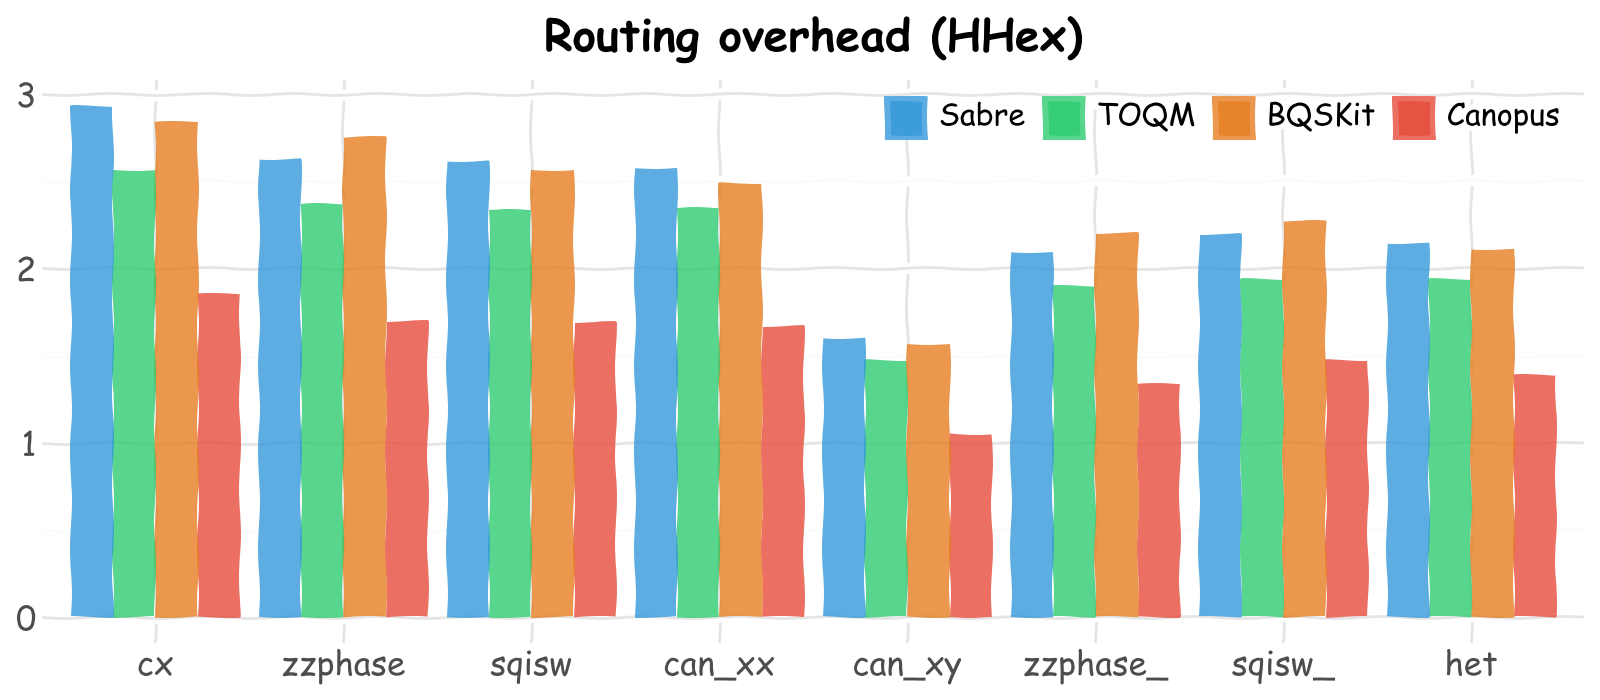

In [18]:
plot_avg_comp3(result_sabre_hhex, result_toqm_hhex, result_bqskit_hhex, result_canopus_hhex, 'Routing overhead (HHex)')


reductions_vs_sabre: ['-34.2%', '-35.98%', '-31.81%', '-36.92%', '-33.56%', '-35.58%', '-30.76%', '-35.02%']
reductions_vs_toqm: ['-28.78%', '-32.47%', '-25.73%', '-34.11%', '-29.73%', '-31.27%', '-24.55%', '-30.8%']
reductions_vs_bqskit: ['-41.91%', '-42.52%', '-33.29%', '-45.48%', '-41.1%', '-45.14%', '-38.24%', '-39.63%']


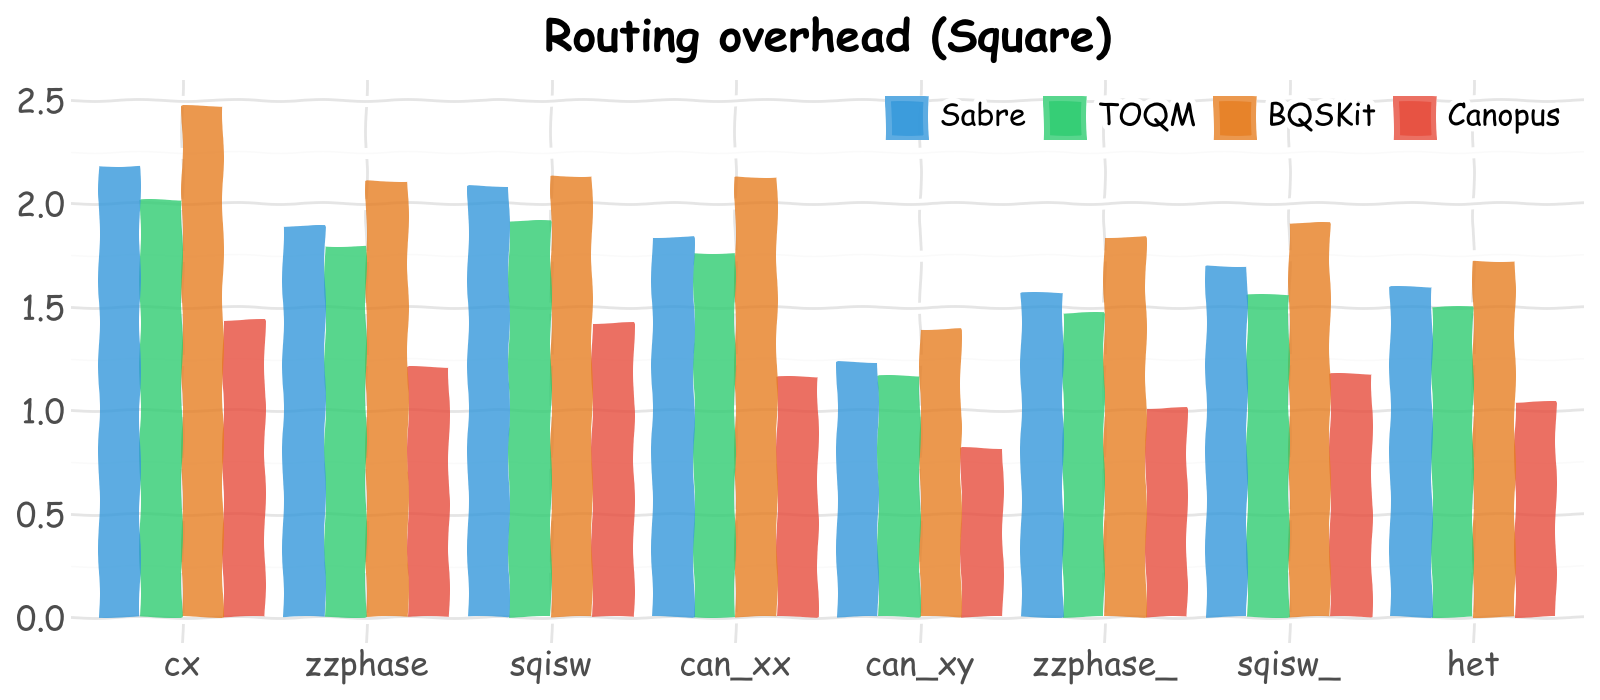

In [19]:
plot_avg_comp3(result_sabre_square, result_toqm_square, result_bqskit_square, result_canopus_square, 'Routing overhead (Square)')